# Microsoft Movie Studios Initial Pitch

## Overview
This project reviews data from IMDB and TheNumbers.com to find the potential most equitable actions that can be taken to produce equitable content by looking at director history, reviewing the domestic, foreign, and global markets, and analyzing budgets against profit margins.

## Business Understanding
Microsoft is looking to produce original video content by opening a new studio. The studio is looking to start off strong with high-value titles from the beginning and justify the studio's initial cost to open.

## Data Understanding

IMDB is one of the biggest and detailed database on movie data. We specifically focused on movie_basics, movie_akas, directors, and persons table from IMDB. Budget data was taken from TheNumbers which provided data on production budget, domestic gross earnings, and worldwide gross earnings. 

We beleive that the "success" of a film can be measured by the revenue that it brings in and some big variables that affect the success of a film's directors, the film's market, and the film's budget.

### IMPORTS AND DATA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import sqlite3
import numpy as np
import seaborn as sns
%matplotlib inline

### Set Plot and Display Defaults

In [2]:
pd.options.display.float_format = '{:20,.2f}'.format
sns.set_theme()
sns.set_palette('colorblind')

TheNumbers has an extensive database of movies matched to their budgets and gross revenues.

In [3]:
budgets_df = pd.read_csv('data/tn.movie_budgets.csv.gz')
display(budgets_df.head())
display(budgets_df.info())

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


None

### IMDB's Database Schema
IMDB has one of the largest databases of movies available.

Data used here include basic movie information (movie_basics), alternative movie titles (movie_akas), and movie directors and their respective names (directors & persons).

![database schema flow chart](./images/db_schema.jpeg)

In [22]:
# REQUIRES UNZIPPING data/im.db.zip AS im.db
conn = sqlite3.connect('data/im.db')

In [4]:
recent_imdb_movies = pd.read_sql("""
SELECT * 
FROM movie_basics
WHERE CAST(start_year AS int) BETWEEN 2013 AND 2023
""", conn)
display(recent_imdb_movies.head())
display(recent_imdb_movies.info())

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,nan,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00,"Comedy,Drama,Fantasy"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107602 entries, 0 to 107601
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         107602 non-null  object 
 1   primary_title    107602 non-null  object 
 2   original_title   107582 non-null  object 
 3   start_year       107602 non-null  int64  
 4   runtime_minutes  82307 non-null   float64
 5   genres           103491 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 4.9+ MB


None

In [5]:
movie_akas = pd.read_sql("""
SELECT *
FROM movie_akas
""", conn)
display(movie_akas.head())
display(movie_akas.info())

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.00
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.00
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.00
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.00
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331703 entries, 0 to 331702
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   movie_id           331703 non-null  object 
 1   ordering           331703 non-null  int64  
 2   title              331703 non-null  object 
 3   region             278410 non-null  object 
 4   language           41715 non-null   object 
 5   types              168447 non-null  object 
 6   attributes         14925 non-null   object 
 7   is_original_title  331678 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 20.2+ MB


None

Since the directors table only has movie_id and person_id, we join the directors using their person_id to get their names

In [6]:
imdb_directors = pd.read_sql("""
SELECT DISTINCT d.movie_id, p.person_id, p.primary_name 
FROM persons as p
INNER JOIN directors AS d
    ON d.person_id = p.person_id
""", conn)

## Data Preparation

### Matching TheNumbers data to IMDB
Use a list of all IMDB titles to match movie IDs from IMDB to movie titles from TheNumbers.

In [7]:
movie_akas = pd.read_sql("""
SELECT DISTINCT movie_id, title FROM movie_akas
""",conn)

In [8]:
movie_akas_list = list(movie_akas['title'])
movie_ids_list = list(movie_akas['movie_id'])

Since directors are a key part of the calculation, we need to associate movie_ids to movies in order to pair the two together through IMDB

In [9]:
budgets_df['movie_id'] = [movie_ids_list[movie_akas_list.index( title )] if title in movie_akas_list 
                          else None for title in budgets_df['movie']]
budgets_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",tt1775309
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",tt1298650
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",tt6565702
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",tt2395427
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",None
...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0,tt7837402
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495",None
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338",None
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0,tt2107644


get rid of entries without a movie_id - director can't be found without this info

### Cleaning budgets_df

In [10]:
budgets_df.dropna(subset=['movie_id'],inplace=True)

In [11]:
budgets_df.drop_duplicates(subset=['movie_id'],inplace=True)

Dollar amounts need to be treated as numbers, so we have to remove dollar sign and commas from our data.

In [12]:
budgets_df['production_budget'] = (budgets_df['production_budget'].str.replace('$', '')
                                   .str.replace(',', '').astype(int))
budgets_df['domestic_gross'] = budgets_df['domestic_gross'].str.replace('$', '').str.replace(',', '').astype(int)
budgets_df['worldwide_gross'] = budgets_df['worldwide_gross'].str.replace('$', '').str.replace(',', '').astype(int)

### Feature Engineering

We created foreign market analysis and margins to determine budget range for future movies.

In [13]:
budgets_df['foreign_gross'] = budgets_df['worldwide_gross'] - budgets_df['domestic_gross']
budgets_df['domestic_margin'] = budgets_df['domestic_gross'] - budgets_df['production_budget']
budgets_df['worldwide_margin'] = budgets_df['worldwide_gross'] - budgets_df['production_budget']
budgets_df['foreign_margin'] = budgets_df['foreign_gross'] - budgets_df['production_budget']

In [14]:
budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,foreign_gross,domestic_margin,worldwide_margin,foreign_margin
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,tt1775309,2015837654,335507625,2351345279,1590837654
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,tt1298650,804600000,-169536125,635063875,394000000
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,tt6565702,107000000,-307237650,-200237650,-243000000
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,tt2395427,944008095,128405868,1072413963,613408095
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,tt4154756,1369318718,378815482,1748134200,1069318718


### Merging budgets with recent IMDB movies
Bringing together more information from IMDB with budget data from TheNumbers

In [15]:
recent_movies = budgets_df.merge(recent_imdb_movies, on="movie_id", how='inner')
recent_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1465 non-null   int64  
 1   release_date       1465 non-null   object 
 2   movie              1465 non-null   object 
 3   production_budget  1465 non-null   int64  
 4   domestic_gross     1465 non-null   int64  
 5   worldwide_gross    1465 non-null   int64  
 6   movie_id           1465 non-null   object 
 7   foreign_gross      1465 non-null   int64  
 8   domestic_margin    1465 non-null   int64  
 9   worldwide_margin   1465 non-null   int64  
 10  foreign_margin     1465 non-null   int64  
 11  primary_title      1465 non-null   object 
 12  original_title     1465 non-null   object 
 13  start_year         1465 non-null   int64  
 14  runtime_minutes    1375 non-null   float64
 15  genres             1460 non-null   object 
dtypes: float64(1), int64(9),

### Merging together recent movies and directors
Bringing together information from the merged recent movies table and directors for our final tabel for director analysis

In [16]:
movies_directors = recent_movies.merge(imdb_directors, on="movie_id", how='inner')
movies_directors.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,foreign_gross,domestic_margin,worldwide_margin,foreign_margin,primary_title,original_title,start_year,runtime_minutes,genres,person_id,primary_name
0,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,tt6565702,107000000,-307237650,-200237650,-243000000,Dark Phoenix,Dark Phoenix,2019,113.00,"Action,Adventure,Sci-Fi",nm1334526,Simon Kinberg
1,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,tt2395427,944008095,128405868,1072413963,613408095,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.00,"Action,Adventure,Sci-Fi",nm0923736,Joss Whedon
2,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,tt4154756,1369318718,378815482,1748134200,1069318718,Avengers: Infinity War,Avengers: Infinity War,2018,149.00,"Action,Adventure,Sci-Fi",nm0751648,Joe Russo
3,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,tt4154756,1369318718,378815482,1748134200,1069318718,Avengers: Infinity War,Avengers: Infinity War,2018,149.00,"Action,Adventure,Sci-Fi",nm0751577,Anthony Russo
4,9,"Nov 17, 2017",Justice League,300000000,229024295,655945209,tt0974015,426920914,-70975705,355945209,126920914,Justice League,Justice League,2017,120.00,"Action,Adventure,Fantasy",nm0811583,Zack Snyder


# Data Analysis

## Getting the the top 15 directros sorted by the median of their worldwide margin 
Here, we wanted to look at the median profits generated from directors' recent movies to reduce the influence of outliers.

Some directors have experience in creating highly profitable films. In recent years, Colin Trevorrow (the director of 2 of the recent _Jurassic World_ films) has been able to generate a median of \\$1.4 billion in profit in his films. The next-highest slot in this list was nearly \\$350 million dollars behind him.

In [17]:
director_wwmargin_median = movies_directors.groupby(
    ['primary_name', 'person_id'], as_index=False
)['worldwide_margin'].median().sort_values(by='worldwide_margin', ascending=False)[:15]
director_wwmargin_median.head()

,primary_name,person_id,worldwide_margin
254,Colin Trevorrow,nm1119880,"1,433,854,864.00"
235,Christophe Gans,nm0304521,"1,099,199,706.00"
668,Joss Whedon,nm0923736,"1,072,413,963.00"
737,Kyle Balda,nm0049633,"1,023,031,961.50"
999,Pierre Coffin,nm1853544,"959,727,750.00"


<ipython-input-18-23975babd822>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(


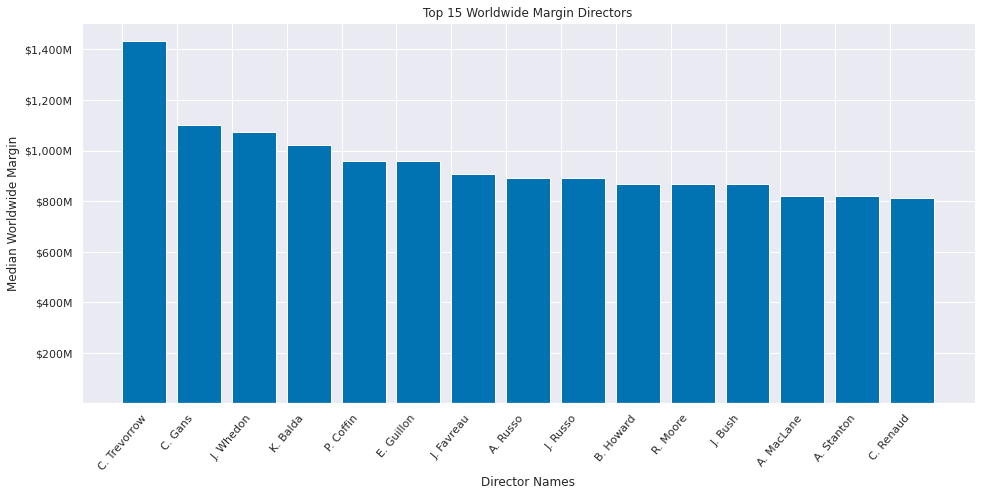

In [18]:
fig, ax = plt.subplots(figsize=(16, 7))

x = director_wwmargin_median['primary_name']
y = director_wwmargin_median['worldwide_margin']

_y_ticks = [(value * 10**8) for value in range(2,14+1,2)]
ax.set(
    title = "Top 15 Worldwide Margin Directors", 
    xlabel = "Director Names",
    xticklabels = [f'{director[0]}. {director.split(" ")[-1]}' for director in x.tolist()],
    ylabel = "Median Worldwide Margin",
    yticks=_y_ticks,
    yticklabels = [f'${int(x/1000000):,}M' for x in _y_ticks]
)

ax.bar(x, y, align='edge')
plt.xticks(rotation=50)
plt.rc('font', size = 25)
"";

## Market Discovery:
Here, we sought to discover if a foreign market or a domestic market would be a better area to focus. We did this by gathering the median gross sales of all regions and compared them to one another, with an additional focus on the top 50 highest grossing movies worldwide.

In [19]:
market_focus_df = budgets_df.loc[
    (budgets_df['foreign_gross'] > 0) & (budgets_df['domestic_gross'] > 0),
    ['worldwide_gross','domestic_gross','foreign_gross']
]
market_focus = {
    'worldwide': {
        'median': market_focus_df['worldwide_gross'].median(),
        'top_median': market_focus_df['worldwide_gross'][:50].median()
    },
    'domestic': {
        'median': market_focus_df['domestic_gross'].median(),
        'top_median': market_focus_df['domestic_gross'][:50].median()
    },
    'foreign': {
        'median': market_focus_df['foreign_gross'].median(),
        'top_median': market_focus_df['foreign_gross'][:50].median()
    }
}

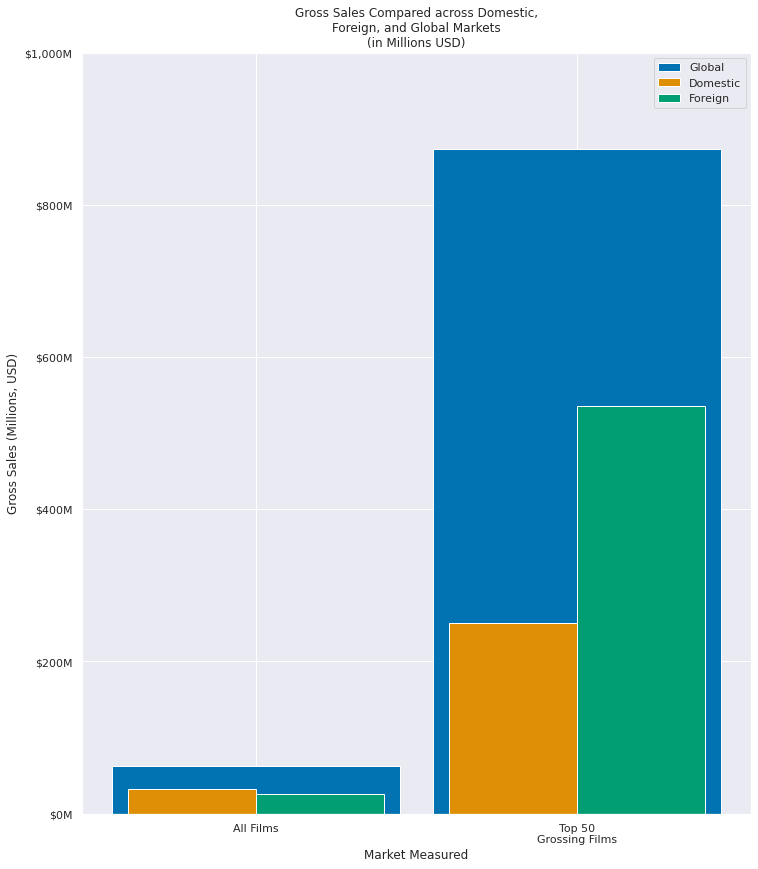

In [20]:
fig, ax = plt.subplots(figsize = (12,14))
sns.set_palette('colorblind')

x = ['All Films','Top 50\nGrossing Films']
_y_ticks = [(value * 10**8) for value in range(0,10+1,2)]

ax.bar(
    x=x,
    height=list(market_focus['worldwide'].values()),
    width=-0.9,
    align='center'
)
ax.bar(
    x=x,
    height=list(market_focus['domestic'].values()),
    width=-0.4,
    align='edge'
)
ax.bar(
    x=x,
    height=list(market_focus['foreign'].values()),
    width=0.4,
    align='edge'
)

ax.set(
    title="Gross Sales Compared across Domestic,\nForeign, and Global Markets\n(in Millions USD)",
    xlabel="Market Measured",
    ylabel="Gross Sales (Millions, USD)",
    yticks=_y_ticks,
    yticklabels = [f'${int(x/1000000):,}M' for x in _y_ticks]
)
ax.legend(['Global','Domestic','Foreign'])
plt.rc('font', size = 25)
'';

We can see here that the domestic market seem to be slightly better than the foreign market across the entire dataset, but for the movies in the highest-grossing subset, the foreign market seems to bring in almost double the value.

## Budget vs Worldwide Profit Margin per Movie

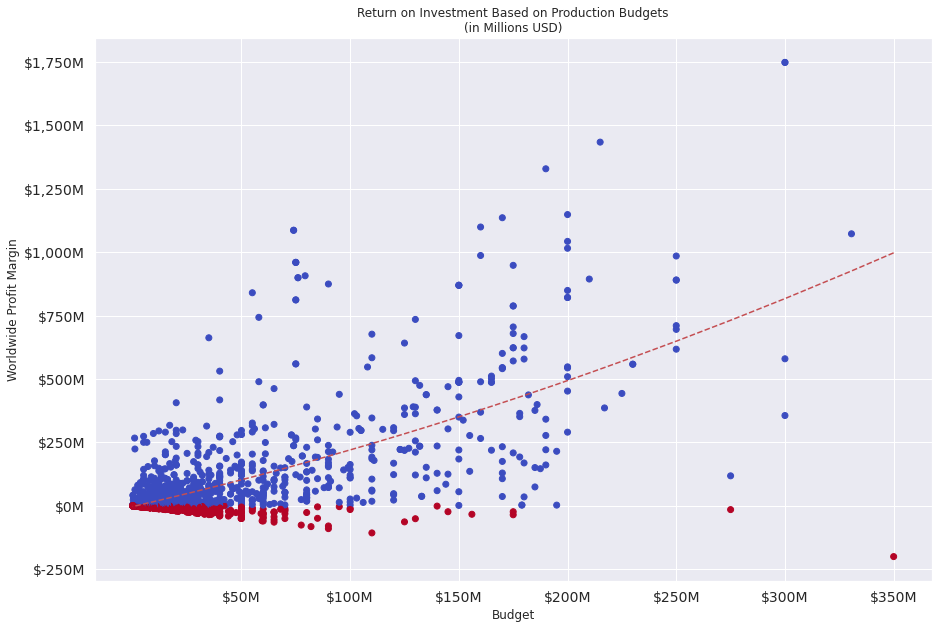

In [21]:
fig, ax = plt.subplots(figsize=(15, 10))

x = movies_directors['production_budget']
y = movies_directors['worldwide_margin']

ax.scatter(
    x=x,
    y=y,
    c=np.sign(y),
    cmap=plt.cm.coolwarm.reversed()
)

_x_ticks = [value * 10**6 for value in range(50,350+1,50)]
_y_ticks = [value * 10**6 for value in range(-250,1750+1,250)]
ax.set(
    title="Return on Investment Based on Production Budgets\n(in Millions USD)",
    xlabel="Budget",
    ylabel="Worldwide Profit Margin",
    xticks=_x_ticks,
    xticklabels = [f'${int(value/1000000):,}M' for value in _x_ticks],
    yticks=_y_ticks,
    yticklabels = [f'${int(value/1000000):,}M' for value in _y_ticks],
)

z = np.polyfit(x, y, 2)
p = np.poly1d(z)

ax.plot(x,p(x),"r--")

plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.rc('font', size = 25)
'';

The scatter plot shows a slight positive correlation for production budget and worldwide profit margin (return on investment) which supports that the more investment made the more return received. In this range, there doesn't seem to be a point of diminishing returns.

## Results

## Conclusions

## Next Step

- name matching
- no new avatar
- we looked at last 10 years so it disregards the first avatar and other big movies so might be worth to go back more
- get or generate a more complete dataset bc lots of mismatches and missing data such as worldwide gross listed as zero and movies with no ids

## Repository structure

## Thank you